In [1]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython.display import clear_output
from sklearn.metrics import r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt

import data_parser
%matplotlib inline

In [2]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA not avaiable


/public/home/zhanghf/.conda/envs/ONN/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def live_plot_X_y(X_train_label, y_train, train_pred=None, X_test_label=None, y_test=None, \
                  test_pred=None, epoch=None, loss=None, mer=None, title=None, savefig=False, figname=None):
    
    clear_output(wait=True)
    
    if X_test_label is not None:
        fig, ax = plt.subplots(2, figsize=(20, 10))
        
        X_train = np.arange(len(X_train_label))
        ax[0].scatter(X_train, y_train.detach().numpy())
        if train_pred is not None:
            ax[0].scatter(X_train, train_pred.detach().numpy())
            
        X_test = np.arange(len(X_test_label))
        ax[1].scatter(X_test, y_test.detach().numpy())
        if test_pred is not None:
            text_kwargs = dict(fontsize=18, )
            ax[1].scatter(X_test, test_pred.detach().numpy())
            plt.text(0, 0, 'Batch %d Loss: %.4f Max Error Rate : %.4f' % (epoch, loss, mer), **text_kwargs)
        
        if title is not None:
            ax[1].set_title(title)
        
    else:
        fig, ax = plt.subplots(1, figsize=(20, 10))
        X_train = np.arange(len(X_train_label))
        ax.scatter(X_train, y_train.detach().numpy())
        if train_pred is not None:
            text_kwargs = dict(fontsize=18, )
            ax.scatter(X, pred.detach().numpy())
            plt.text(0, 0, 'Batch %d Loss: %.4f Max Error Rate : %.4f' % (epoch, loss, mer), **text_kwargs)
        if title is not None:
            ax[1].set_title(title)
    
    if savefig == True:
        plt.savefig('../Figures/pdf/'+figname+'.pdf')
        plt.savefig('../Figures/png/'+figname+'.png')
    plt.show();

In [15]:
class data_processor():
    def __init__(self):
        self.dict = {}
    
    def initial_normalize(self, X, y):
        self.dict['X_std'] = X.std(dim=0)
        self.dict['X_mean'] = X.mean(dim=0)
        self.dict['y_std'] = y.std(dim=0)
        self.dict['y_mean'] = y.mean(dim=0)
        # new_X = (X - self.dict['X_mean']) / self.dict['X_std']
        # new_y = (y - self.dict['y_mean']) / self.dict['y_std']
        # return new_X, new_y
        return
    
    def normalize(self, X=None, y=None):
        new_X, new_y = None, None
        if X is not None:
            new_X = (X - self.dict['X_mean']) / self.dict['X_std']
        if y is not None:
            new_y = (y - self.dict['y_mean']) / self.dict['y_std']
        return new_X, new_y
        
    def denormalize(self, X=None, y=None):
        original_X, original_y = None, None
        if X is not None:
            original_X = X * self.dict['X_std'] + self.dict['X_mean']
        if y is not None:    
            original_y = y * self.dict['y_std'] + self.dict['y_mean']
        return original_X, original_y
        

class single_frequency_point_MLP_6(nn.Module):
    def __init__(self):
        super(single_frequency_point_MLP_6, self).__init__()
        # Define the layers in the model
        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, x):
        # Forward propagation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias.data)

def train(df, frequency_point, input_cols, output_col, unwrap, result_config):
    
    # Preprocess the dataset based on frequency point
    df_fp = df.xs(frequency_point, level=1)
    idx = df_fp.index.to_numpy()
    X = df_fp[input_cols].to_numpy()
    y = df_fp[output_col].to_numpy().reshape(-1, 1)
    index_len = len(idx)
    index_list = list(range(index_len))
    
    # Define Model name, figure title and figure name
    modelpath = '../Models/single_frequency_point/'+ output_col + '_' + str(0.2 * frequency_point).replace('.', 'd') + 'GHz.pt'
    figtitle = output_col + 'at frequency point ' + str(0.2 * frequency_point) + ' GHz'
    if unwrap == False:
        figname = output_col + '_' + str(0.2 * frequency_point).replace('.', 'd') + 'GHz'
    else:
        figname = output_col + '_' + str(0.2 * frequency_point).replace('.', 'd') + 'GHz' + '_unwrap'
    # Randomly shuffle the indices
    random.seed(42)
    np.random.shuffle(index_list)

    # Split the indices into 80% training set, 10% testing set and 10% validation set
    train_idx = index_list[:int(len(index_list) * 0.8)]
    test_idx = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
    val_idx = index_list[int(len(index_list) * 0.9):]

    idx_train, X_train, y_train = idx[train_idx], torch.Tensor(X[train_idx]).to(device), torch.Tensor(y[train_idx]).to(device)
    idx_test, X_test, y_test = idx[test_idx], torch.Tensor(X[test_idx]).to(device), torch.Tensor(y[test_idx]).to(device)
    idx_val, X_val, y_val = idx[val_idx], torch.Tensor(X[val_idx]).to(device), torch.Tensor(y[val_idx]).to(device)

    # Preprocess the data
    dp = data_processor()
    dp.initial_normalize(torch.Tensor(X).to(device), torch.Tensor(y).to(device))
    X_train_norm, y_train_norm = dp.normalize(X_train, y_train)
    X_test_norm, y_test_norm = dp.normalize(X_test, y_test)
    X_val_norm, y_val_norm = dp.normalize(X_val, y_val)
    
    model = single_frequency_point_MLP_6()
    learning_rate = 0.01
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
    model = model.to(device)

    epoch = 0
    num_epochs = 3000
    # Define the loss function
    criterion = nn.MSELoss()

    #for epoch in range(num_epochs)
    train_loss = 1.0

    #X_train_norm = X_train_norm.to(device)
    #y_train_norm = y_train_norm.to(device)
    #X_test_norm = X_test_norm.to(device)
    #y_test_norm = y_test_norm.to(device)
    #X_val_norm = X_val_norm.to(device)
    #y_val_norm = y_val_norm.to(device)
    
    best_val_mse = 100.0
    best_val_mer = -100.0
    best_val_r2 = -100.0
    
    for epoch in range(num_epochs):

        # Clear the gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(X_train_norm)

        # Calculate the loss function
        loss = criterion(outputs, y_train_norm)

        _, orignial_outputs = dp.denormalize(y=outputs)
        _, original_y_train = dp.denormalize(y=y_train_norm)

        # Backward propagation
        loss.backward()

        # Update parameters
        optimizer.step()
        
        # Validation
        if epoch % 100 == 99: 

            with torch.no_grad():

                # Make predictions on the test data
                predictions = model(X_val_norm)

                # Calculate the loss function
                val_loss = criterion(predictions, y_val_norm)

                # Track the loss value 
                val_loss = val_loss.item()  

                _, orignial_predictions = dp.denormalize(y=predictions)
                _, original_y_val = dp.denormalize(y=y_val_norm)

                # Compute the R^2 score
                r2 = r2_score(orignial_predictions.detach().cpu().numpy(), original_y_val.detach().cpu().numpy())
                
                # Compute the max error rate
                mer = torch.max(torch.abs(orignial_predictions % (2 * np.pi) - original_y_val % (2 * np.pi)) / np.pi / 2)
                
                # Save best model
                if val_loss < best_val_mse:
                    best_val_mse = val_loss
                    best_val_mer = mer
                    torch.save(model.state_dict(), modelpath) 

                live_plot_X_y(idx_train, original_y_train.cpu(), orignial_outputs.cpu(), idx_val, \
                              original_y_val.cpu(), orignial_predictions.cpu(), epoch + 1, val_loss, \
                              mer, title=figtitle, savefig=((epoch + 1) == num_epochs), figname=figname)
    
    # Testing
    
    model.load_state_dict(torch.load(modelpath))
    with torch.no_grad():

        # Make predictions on the test data
        predictions = model(X_test_norm)

        # Calculate the loss function
        test_loss = criterion(predictions, y_test_norm)

        # Track the loss value 
        test_loss = test_loss.item()  
        
        _, orignial_predictions = dp.denormalize(y=predictions)
        _, original_y_test = dp.denormalize(y=y_test_norm)
        
        # Compute the R^2 score
        r2 = r2_score(orignial_predictions.detach().cpu().numpy(), original_y_test.detach().cpu().numpy())
        
        # Compute the max error rate
        mer = torch.max(torch.abs(orignial_predictions % (2 * np.pi) - original_y_test % (2 * np.pi)) / np.pi / 2)
    
    # Save results
    result_lst = [[2e8 * frequency_point, output_col, best_val_mse, best_val_mer, test_loss, mer]]
    result_config['df'] = pd.concat([result_config['df'], pd.DataFrame(result_lst, columns=result_config['columns'])], ignore_index=True)
    return result_config

In [5]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(), unwrap=False) # unwrap the phase

In [8]:
df_unwrap = data_parser.calculate_amp_phase(data_parser.data_parse()) # unwrap the phase

In [9]:
columns = ['F', 'S_parameter', 'best_val_mse', 'best_val_mer', 'test_mse', 'test_mer']
result_config = {}
result_config['df'] = pd.DataFrame(columns=columns)
result_config['columns'] = columns

result_config_unwrap = {}
result_config_unwrap['df'] = pd.DataFrame(columns=columns)
result_config_unwrap['columns'] = columns

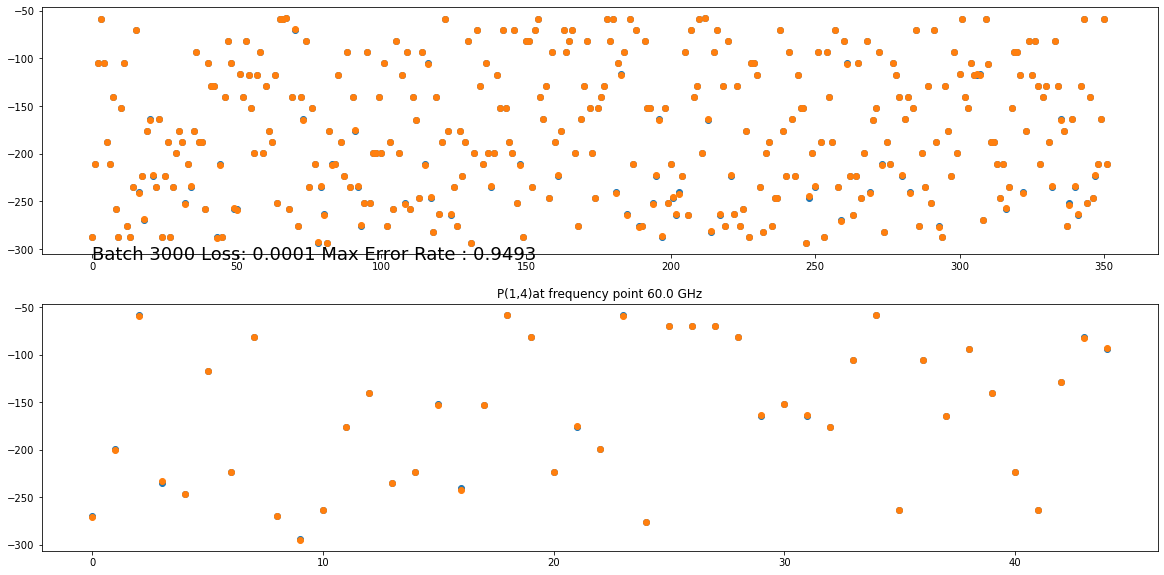

In [16]:
input_cols = ["W", "Trap", "Length"]
frequency_points_lst = [300]
for frequency_point in frequency_points_lst:
    for i in 1, :
        for j in 1, 2, 3, 4:
            # Define output index
            out_idx = '('+str(i)+','+str(j)+')'
            # A_col = 'A'+out_idx
            # result_config = train(df, frequency_point, input_cols, A_col, result_config)
            P_col = 'P'+out_idx
            result_config = train(df, frequency_point, input_cols, P_col, False, result_config)
            result_config_unwrap = train(df_unwrap, frequency_point, input_cols, P_col, True, result_config)

result_config['df'].to_csv('../Data/Out/single_frequency_point_result_phase.csv')
result_config_unwrap['df'].to_csv('../Data/Out/single_frequency_point_result_phase_unwrap.csv')


In [ ]:
def test_normalize(df, frequency_point, input_cols, output_col, result_config):
    
    # Preprocess the dataset based on frequency point
    df_fp = df.xs(frequency_point, level=1)
    idx = df_fp.index.to_numpy()
    X = df_fp[input_cols].to_numpy()
    y = df_fp[output_col].to_numpy().reshape(-1, 1)
    index_len = len(idx)
    index_list = list(range(index_len))
    
    # Define Model name, figure title and figure name
    modelpath = '../Models/single_frequency_point/'+ output_col + '_' + str(0.2 * frequency_point).replace('.', 'd') + 'GHz.pt'
    figtitle = output_col + 'at frequency point ' + str(0.2 * frequency_point) + ' GHz'
    figname = output_col + '_' + str(0.2 * frequency_point).replace('.', 'd') + 'GHz'

    # Randomly shuffle the indices
    random.seed(42)
    np.random.shuffle(index_list)

    # Split the indices into 80% training set, 10% testing set and 10% validation set
    train_idx = index_list[:int(len(index_list) * 0.8)]
    test_idx = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
    val_idx = index_list[int(len(index_list) * 0.9):]

    idx_train, X_train, y_train = idx[train_idx], torch.Tensor(X[train_idx]).to(device), torch.Tensor(y[train_idx]).to(device)
    idx_test, X_test, y_test = idx[test_idx], torch.Tensor(X[test_idx]).to(device), torch.Tensor(y[test_idx]).to(device)
    idx_val, X_val, y_val = idx[val_idx], torch.Tensor(X[val_idx]).to(device), torch.Tensor(y[val_idx]).to(device)
    
    # Preprocess the data
    dp = data_processor()
    dp.initial_normalize(torch.Tensor(X).to(device), torch.Tensor(y).to(device))
    X_train_norm, y_train_norm = dp.normalize(X_train, y_train)
    X_test_norm, y_test_norm = dp.normalize(X_test, y_test)
    X_val_norm, y_val_norm = dp.normalize(X_val, y_val)
    
    print(y_train)
    print(y_train_norm)
    
    _, original_y_train = dp.denormalize(None, y_train_norm)
    
    print(original_y_train - y_train)


In [ ]:
input_cols = ["W", "Trap", "Length"]
frequency_points_lst = [100]
for frequency_point in frequency_points_lst:
    for i in 1, :
        for j in 1, :
            # Define output index
            out_idx = '('+str(i)+','+str(j)+')'
            # A_col = 'A'+out_idx
            # result_config = train(df, frequency_point, input_cols, A_col, result_config)
            P_col = 'P'+out_idx
            result_config = test_normalize(df, frequency_point, input_cols, P_col, result_config)

In [ ]:
###############
# For Back up #
###############

In [ ]:

df_fp = df.xs(frequency_point, level=1)
idx = df_fp.index.to_numpy()
X = df_fp[input_cols].to_numpy()
# X = np.tile(X, (1, 20))
y = df_fp[output_cols].to_numpy().reshape(-1, 1)

In [ ]:
index_len = len(idx)
index_list = list(range(index_len))

# Randomly shuffle the indices
random.seed(42)
np.random.shuffle(index_list)

# Split the indices into 80% training set, 10% testing set and 10% validation set
train_idx = index_list[:int(len(index_list) * 0.8)]
test_idx = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
val_idx = index_list[int(len(index_list) * 0.9):]

idx_train, X_train, y_train = idx[train_idx], torch.Tensor(X[train_idx]), torch.Tensor(y[train_idx])
idx_test, X_test, y_test = idx[test_idx], torch.Tensor(X[test_idx]), torch.Tensor(y[test_idx])
idx_val, X_val, y_val = idx[val_idx], torch.Tensor(X[val_idx]), torch.Tensor(y[val_idx])

# Preprocess the data
dp = data_processor()
dp.initial_normalize(torch.Tensor(X), torch.Tensor(y))
X_train_norm, y_train_norm = dp.normalize(X_train, y_train)
X_test_norm, y_test_norm = dp.normalize(X_test, y_test)
X_val_norm, y_val_norm = dp.normalize(X_val, y_val)

In [ ]:
class single_frequency_point_MLP_6(nn.Module):
    def __init__(self):
        super(single_frequency_point_MLP_6, self).__init__()
        # Define the layers in the model
        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, x):
        # Forward propagation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias.data)

In [ ]:
model = single_frequency_point_MLP_6()
learning_rate = 0.01
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
model = model.to(device)

epoch = 0
num_epochs = 30000
# Define the loss function
criterion = nn.MSELoss()

#for epoch in range(num_epochs)
train_loss = 1.0

X_train_norm.to(device)
y_train_norm.to(device)
X_test_norm.to(device)
y_test_norm.to(device)

for epoch in range(num_epochs):
    
    # Clear the gradients
    optimizer.zero_grad()

    # Forward propagation
    outputs = model(X_train_norm)

    # Calculate the loss function
    loss = criterion(outputs, y_train_norm)

    _, orignial_outputs = dp.denormalize(y=outputs)
    _, original_y_train = dp.denormalize(y=y_train_norm)
    # live_plot_X_y(idx_train, original_y_train.cpu(), orignial_outputs.cpu(), epoch + 1, train_loss, r2)
    
    # Backward propagation
    loss.backward()

    # Update parameters
    optimizer.step()

    if epoch % 100 == 99: 
            
        with torch.no_grad():

            # Make predictions on the test data
            predictions = model(X_test_norm)

            # Calculate the loss function
            val_loss = criterion(predictions, y_test_norm)

            # Track the loss value 
            val_loss = val_loss.item()  

            _, orignial_predictions = dp.denormalize(y=predictions)
            _, original_y_test = dp.denormalize(y=y_test_norm)

            # Import the r2_score function
            from sklearn.metrics import r2_score

            # Compute the R^2 score
            r2 = r2_score(orignial_predictions.detach().cpu().numpy(), original_y_test.detach().cpu().numpy())
            
            live_plot_X_y(idx_train, original_y_train.cpu(), orignial_outputs.cpu(), idx_test, original_y_test.cpu(), orignial_predictions.cpu(), epoch + 1, val_loss, r2)
        # Print the statistics of the epoch 
        # print(predictions[0:10].detach().numpy(), y_test[0:10].detach().numpy())
        # for param in model.parameters():
        #     print(param.data)
        # print('Completed training batch', epoch + 1, 'Training Loss is: %.4f' %loss, 'Validation Loss is: %.4f' %val_loss, 'R2 is %.4f' % (r2))
        